<a href="https://colab.research.google.com/github/GiuliaFContardi/FL_IDS-GAN/blob/main/preprocessingCICIDS2017_v2_varianza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Collegamento a Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

## Import dei Dataset csv dal Drive

In [ ]:
# import dei csv del dataset CIC-IDS-2017 migliorato da ricercatori Liu et al.(2022) - https://intrusion-detection.distrinet-research.be/CNS2022/
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2017/improved/thursday.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2017/improved/friday.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2017/improved/monday.csv')
df4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2017/improved/tuesday.csv')
df5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/progettoTesi/Dataset2017/improved/wednesday.csv')

# merge dataframes
df = pd.concat([df1,df2,df3,df4,df5])

del df1
del df2
del df3
del df4
del df5

In [ ]:
# display the different types of network data which will later be classified and synthetically recreated.
df['Label'].value_counts()

BENIGN                                    1582566
Portscan                                   159066
DoS Hulk                                   158468
DDoS                                        95144
Infiltration - Portscan                     71767
DoS GoldenEye                                7567
Botnet - Attempted                           4067
FTP-Patator                                  3972
DoS Slowloris                                3859
DoS Slowhttptest - Attempted                 3368
SSH-Patator                                  2961
DoS Slowloris - Attempted                    1847
DoS Slowhttptest                             1740
Web Attack - Brute Force - Attempted         1292
Botnet                                        736
Web Attack - XSS - Attempted                  655
DoS Hulk - Attempted                          581
DoS GoldenEye - Attempted                      80
Web Attack - Brute Force                       73
Infiltration - Attempted                       45


## Primi aggiustamenti di pre-processing

In [ ]:
#come da avviso del paper si considerano Benign tutti gli "Attempted"
df.loc[df["Attempted Category"] != -1, "Label"] = "BENIGN"
df['Label'].value_counts()

BENIGN                        1594545
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: Label, dtype: int64

Si segue fonte Ali et al. (2023) per il preprocessing:



---




*   raccolgo attacchi DoS
*   raccolgo BruteForce
*   mantengo XXS, SQLinj e SSLexploit che raccolgo in WebAttack
*   raccolgo i rimanenti che sono separati




In [ ]:
# create the final training dataset
clean_df = df.copy()
#cancella attempted ed id colonna perché inutile
clean_df = clean_df.drop('Attempted Category', axis=1)
clean_df = clean_df.drop('id', axis=1)

#si raggruppa considerando la categoria di attacchi Ali et al. (2023) tabella 2 p.11
clean_df.loc[clean_df["Label"] == 'Infiltration', "Label"] = "Infiltration - Portscan"
clean_df.loc[clean_df["Label"] == 'Web Attack - XSS', "Label"] = "WebAttacks"
clean_df.loc[clean_df["Label"] == 'Web Attack - SQL Injection', "Label"] = "WebAttacks"
clean_df.loc[clean_df["Label"] == 'Heartbleed', "Label"] = "WebAttacks"

#unisco in DoS
clean_df.loc[clean_df["Label"] == 'DoS Hulk', "Label"] = "DoS"
clean_df.loc[clean_df["Label"] == 'DoS GoldenEye', "Label"] = "DoS"
clean_df.loc[clean_df["Label"] == 'DoS Slowloris', "Label"] = "DoS"
clean_df.loc[clean_df["Label"] == 'DoS Slowhttptest', "Label"] = "DoS"
#unisco Brute Force
clean_df.loc[clean_df["Label"] == 'Web Attack - Brute Force', "Label"] = "BruteForce"
clean_df.loc[clean_df["Label"] == 'FTP-Patator', "Label"] = "BruteForce"
clean_df.loc[clean_df["Label"] == 'SSH-Patator', "Label"] = "BruteForce"

#rinomino categoria ed unisco a Portscan
clean_df.loc[clean_df["Label"] == 'Infiltration - Portscan', "Label"] = "Infiltration_Portscan"
clean_df.loc[clean_df["Label"] == 'Portscan', "Label"] = "Infiltration_Portscan"

clean_df['Label'].value_counts()

BENIGN                   1594545
Infiltration_Portscan     230869
DoS                       171634
DDoS                       95144
BruteForce                  7006
Botnet                       736
WebAttacks                    42
Name: Label, dtype: int64

In [ ]:
#Poblemi di generazione per la GAN: i label che hanno pochi dati daranno problemi nella creazione ... servono almeno 200-500 sample
#cit Kurniabudi, Stiawan et al. (2020)
#Si decide di droppare la categoria WebAttack per pochi elementi in quanto non si può unire ad altri
clean_df.drop(clean_df.loc[clean_df['Label']=='WebAttacks'].index, inplace=True) #solo 6 classi per muilticlassificazione - ottimo per la GAN
clean_df['Label'].value_counts()

BENIGN                   1594427
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
Name: Label, dtype: int64

In [ ]:
clean_df.shape #sono presenti moltissime feature... 89

(2099774, 89)

# Feature engineering e pulizia del dataset

##Primi step

In [ ]:
#####Pulizia del dataset
#Import librerie per preprocessing e visualization
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

#re-indicizzo random in modo che non rimangano concatenati i dataset dei giorni per fare dopo lo splitting ed avere un minimo di uniformitàDistrib dei dati negli split
from sklearn.utils import shuffle
clean_df = shuffle(clean_df).reset_index()
clean_df = clean_df.drop("index", axis=1) #elimino colonna indice creata dal reset_index

NameError: name 'clean_df' is not defined

Si segue fonte Ali et al. (2023) per il preprocessing:



---




* elimino IP, timestamp e flowID in quanto possono essere spoofati




In [ ]:
#elimino feature non utili
clean_df = clean_df.drop('Src IP', axis=1)
clean_df = clean_df.drop('Dst IP', axis=1)
clean_df = clean_df.drop('Timestamp', axis=1)
clean_df = clean_df.drop('Flow ID', axis=1)

In [ ]:
clean_df.shape # 89 ===> 85 feature

(2099774, 85)

## Altre tecniche pre-processing

In [ ]:
#SALVO CSV Prima del pre-processing vero ...potesse servirmi per cambiare e fare altro
clean_df.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/dataNONpreprocess.csv', index = False)

In [ ]:
#rinomino colonne togliendo spazi fastidiosi
clean_df.columns = clean_df.columns.str.replace(' ', '')

### Check NaN, 0...


In [ ]:
#CIT - https://www.kaggle.com/code/filipekoriginal/cicids2017-preprocessing/notebook#DETECTING-HIGHLY-CORRELATED-PAIRS

# searching for NA values - empty "" are not considered NA
pd.options.mode.use_inf_as_na = True ##infinito è trattato come NA
print(clean_df.loc[:, clean_df.isnull().any()].isnull().sum())
print("=====================")

### NA values are minority of the dataset. Because they cannot be processed by algorithms => cancello
clean_df = clean_df.dropna()
print(clean_df.shape)
print("=====================")

### tolgo feature ridondanti
describe_info = clean_df.describe()
all_zeroes_cols = describe_info.loc[:,(describe_info.iloc[1:] == 0).all()]
clean_df.drop(columns=all_zeroes_cols, inplace=True)
print(all_zeroes_cols)
#[] output ==> non ci sono ridondanze

FlowBytes/s      5
FlowPackets/s    5
dtype: int64
(2099769, 85)
Empty DataFrame
Columns: []
Index: [count, mean, std, min, 25%, 50%, 75%, max]


<ipython-input-15-90e15abfd34a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.drop(columns=all_zeroes_cols, inplace=True)


In [ ]:
#droppo colonne di tutti 0
clean_df = clean_df.loc[:, (clean_df != 0).any(axis=0)]
clean_df.shape
#non ci sono

(2099769, 85)

In [ ]:
#droppo righe di tutti 0
clean_df[~(clean_df == 0).all(axis=1)]
clean_df.shape
#non ci sono

(2099769, 85)

In [ ]:
#doppio check INF as NA
with pd.option_context('mode.use_inf_as_na', True):
  clean_df.dropna(inplace=True)

#### Visualization

<ipython-input-20-0197b6294bc8>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="traffic type", data=df_plot, palette=["g","r"])


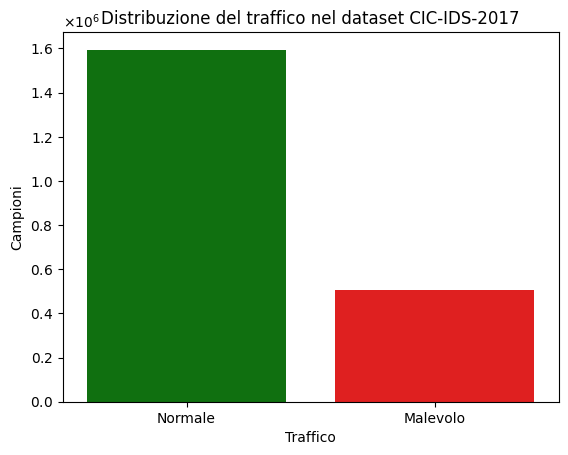

In [ ]:
## temporarily add new column to distinguish traffic type between Normal / Attack
df_plot = clean_df.copy()
trf_type = df_plot.loc[:, "Label"].map(lambda lbl: "Normale" if lbl == "BENIGN" else "Malevolo")
trf_type.name = "traffic type"
df_plot.loc[:, trf_type.name] = trf_type

### plot distrtibution of Normal traffic and Attacks in the whole dataset
plt.ticklabel_format(axis='y', useMathText=True, useOffset=False)  # change def ScalarFormatter

sns.countplot(x="traffic type", data=df_plot, palette=["g","r"])
plt.title("Distribuzione del traffico nel dataset CIC-IDS-2017")
plt.xlabel("Traffico")
plt.ylabel("Campioni")
#salva in Drive
images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf/preprocessing'
plt.savefig(f"{images_dir}/distributionCICIDS2017.pdf", dpi=200, format='pdf')
plt.show()

## Analisi delle feature per eliminare feature inutili
* Importanza
* Varianza 0

In [ ]:
df_importance = clean_df.copy()

## feature selection phase - let's use RFC on our data
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=10, n_jobs=-1) # 100 trees in forest

## feature selection phase - prepare data for RFC
lbls = df_importance.loc[:, "Label"]
data_w_o_cat_attrs = df_importance.iloc[:, :-2]

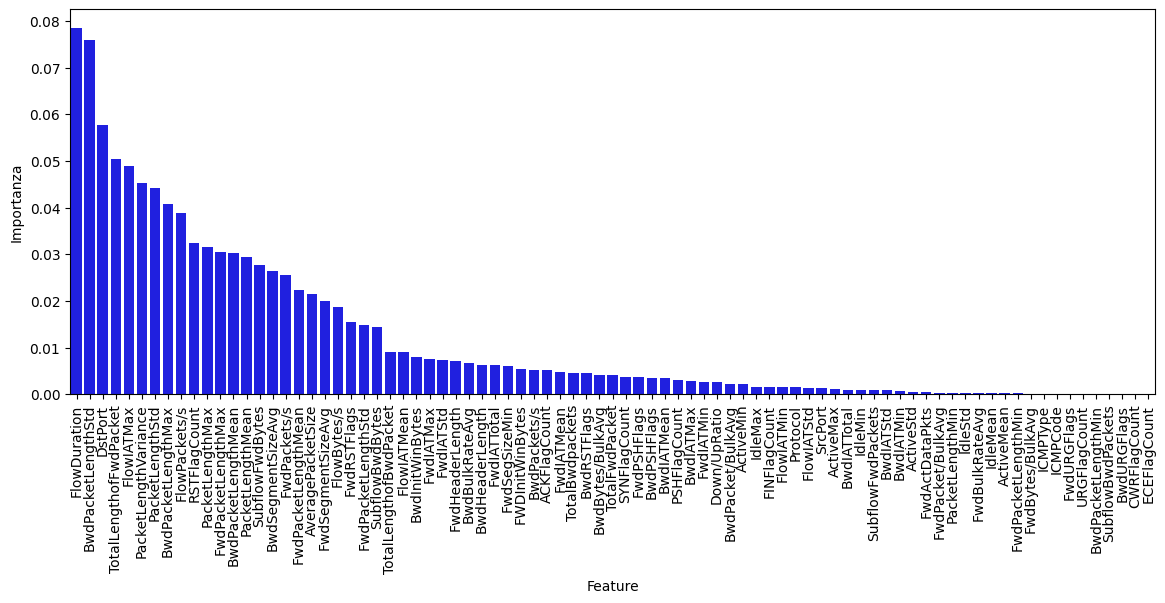

In [ ]:
# fit random forest classifier on the dataset
rfc.fit(data_w_o_cat_attrs, lbls)
RandomForestClassifier(n_jobs=-1, random_state=10)
## plotting features' importance in the whole dataset graph
# extract important features
score = np.round(rfc.feature_importances_,5)
importances = pd.DataFrame({'Feature':data_w_o_cat_attrs.columns,'Importanza':score})
importances = importances.sort_values('Importanza',ascending=False).set_index('Feature')
importances.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/importancesDF_analysis.csv')

# plot importances
sns.barplot(x=importances.index, y="Importanza", data=importances, color="b")
plt.xticks(rotation="vertical")
plt.gcf().set_size_inches(14,5)
plt.savefig(f"{images_dir}/importanzaFeatureCICIDS2017.pdf", dpi=200, format='pdf', bbox_inches = "tight", pad_inches=0.2)
plt.show()

In [ ]:
## Let's leave only the most important features
threshold = 0.0002 # importance threshold - abbassato per non togliere troppe feature che verranno controllate poi con la varianza

bl_thresh = importances.loc[importances["Importanza"] < threshold]
print("there are {} features to delete, as they are below chosen threshold".format(bl_thresh.shape[0]))
print("these features are the following:")
feats_to_del = [feat for feat in bl_thresh.index]
print("\n".join(feats_to_del))


there are 11 features to delete, as they are below chosen threshold
these features are the following:
FwdPacketLengthMin
FwdBytes/BulkAvg
ICMPType
ICMPCode
FwdURGFlags
URGFlagCount
BwdPacketLengthMin
SubflowBwdPackets
BwdURGFlags
CWRFlagCount
ECEFlagCount


In [ ]:
#Si toglie dall'array 1 feature ritenuta importanti nel paper Ali et al(2023)
feats_to_del.remove('BwdPacketLengthMin')
print(feats_to_del)

['FwdPacketLengthMin', 'FwdBytes/BulkAvg', 'ICMPType', 'ICMPCode', 'FwdURGFlags', 'URGFlagCount', 'SubflowBwdPackets', 'BwdURGFlags', 'CWRFlagCount', 'ECEFlagCount']


In [ ]:
## removing these not important features
df_importance.drop(columns=feats_to_del, inplace=True) #10 feature tolte per poca importanza

#### Varianza

In [ ]:
#controllo la varianza delle feature per poi eliminarle se hanno basso o quasi-0 varianza
pd.options.display.float_format = '{:,.20f}'.format
pd.set_option('display.max_rows', df_importance.shape[0]+1)
df_importance.var()


<ipython-input-28-a5681834e905>:4: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_importance.var()


SrcPort                              254,541,707.04207941889762878418
DstPort                               33,880,467.42817547917366027832
Protocol                                      30.27228213485205898792
FlowDuration                 962,822,731,115,647.50000000000000000000
TotalFwdPacket                           757,591.90113243157975375652
TotalBwdpackets                        1,341,040.47748314938507974148
TotalLengthofFwdPacket               109,438,597.34685671329498291016
TotalLengthofBwdPacket         6,903,930,438,923.56445312500000000000
FwdPacketLengthMax                       241,862.77521208740654401481
FwdPacketLengthMean                        8,410.55739825980708701536
FwdPacketLengthStd                        24,058.87569219352371874265
BwdPacketLengthMax                     5,062,514.00215599406510591507
BwdPacketLengthMin                         5,498.39049710802464687731
BwdPacketLengthMean                      449,945.45634464459726586938
BwdPacketLengthStd  

Feature con 0 varianza
```
FwdRSTFlags                                    0.75436721398006911787
BwdRSTFlags                                    0.16196824729130132603
FINFlagCount                                   0.95653599537860134472
RSTFlagCount                                   0.86335375735224939575
Down/UpRatio                                   0.06843146539131091111
* SubflowFwdPackets                              0.02553525700587332137
```

Feature eliminate dal paper di riferimento:BwdPSHFlags,
BwdURGFlags, FwdBulkRateAvg, FwdBytes, BulkAvg,
FwdPacket/BulkAvg, FwdURGFlags, **SubﬂowBwdPackets**,
and URGFlagCount.


Di seguito si verificano le varianze delle rimanenti:

In [ ]:
#Si decide di eliminare le seguenti feature con varianza circa < 0.1
columDel = ['SubflowFwdPackets', 'Down/UpRatio']
df_importance.drop(columns=columDel, inplace=True)

df_importance.shape

KeyError: "['SubflowFwdPackets', 'Down/UpRatio'] not found in axis"

### Correlazioni

In [ ]:
df_importance = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/dataCleanedEncoded.csv')

In [ ]:
df_importance

,SrcPort,DstPort,Protocol,FlowDuration,TotalFwdPacket,TotalBwdpackets,TotalLengthofFwdPacket,TotalLengthofBwdPacket,FwdPacketLengthMax,FwdPacketLengthMean,...,IdleStd,IdleMax,IdleMin,TotalTCPFlowTime,L_BENIGN,L_Botnet,L_BruteForce,L_DDoS,L_DoS,L_Infiltration_Portscan
0,58373,53,17,143,2,2,60,344,30,30.000000,...,0.0,0,0,0,1,0,0,0,0,0
1,55498,80,6,19007,8,6,415,11595,415,51.875000,...,0.0,0,0,19007,0,0,0,0,1,0
2,41854,80,6,5290991,6,6,412,2530,412,68.666667,...,0.0,5000095,5000095,5290991,1,0,0,0,0,0
3,62448,443,6,191714,12,7,1275,687,1029,106.250000,...,0.0,0,0,191714,1,0,0,0,0,0
4,25896,53,17,157,2,2,68,158,34,34.000000,...,0.0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099764,41808,80,6,366990,9,7,704,11595,352,78.222222,...,0.0,0,0,366990,0,0,0,0,1,0
2099765,37058,80,6,5826531,4,2,0,0,0,0.000000,...,0.0,5767733,5767733,5826531,1,0,0,0,0,0
2099766,62529,53,17,258,2,2,66,252,33,33.000000,...,0.0,0,0,0,1,0,0,0,0,0
2099767,57282,53,17,168,2,2,54,86,27,27.000000,...,0.0,0,0,0,1,0,0,0,0,0


In [ ]:
labels = ['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet']

In [ ]:
# Extracting the column with one-hot encoding
encoded_column = df_importance.filter(like='L_')

# Getting the label with the maximum value (1) for each row
decoded_labels = encoded_column.idxmax(axis=1)

# Removing the 'L_' prefix
decoded_labels = decoded_labels.str.replace('L_', '')

# Adding the decoded_labels column to the original DataFrame
df_importance['Label'] = decoded_labels

In [ ]:
# Dropping the one-hot encoded columns
df_importance = df_importance.drop(columns=encoded_column.columns)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Label' column
df_importance['Label'] = label_encoder.fit_transform(df_importance['Label'])

In [ ]:
# Displaying the resulting DataFrame
df_importance

,SrcPort,DstPort,Protocol,FlowDuration,TotalFwdPacket,TotalBwdpackets,TotalLengthofFwdPacket,TotalLengthofBwdPacket,FwdPacketLengthMax,FwdPacketLengthMean,...,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,TotalTCPFlowTime,Label
0,58373,53,17,143,2,2,60,344,30,30.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,0
1,55498,80,6,19007,8,6,415,11595,415,51.875000,...,0.0,0.0,0,0,0.0,0.0,0,0,19007,4
2,41854,80,6,5290991,6,6,412,2530,412,68.666667,...,194282.0,0.0,194282,194282,5000095.0,0.0,5000095,5000095,5290991,0
3,62448,443,6,191714,12,7,1275,687,1029,106.250000,...,0.0,0.0,0,0,0.0,0.0,0,0,191714,0
4,25896,53,17,157,2,2,68,158,34,34.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099764,41808,80,6,366990,9,7,704,11595,352,78.222222,...,0.0,0.0,0,0,0.0,0.0,0,0,366990,4
2099765,37058,80,6,5826531,4,2,0,0,0,0.000000,...,29481.0,0.0,29481,29481,5767733.0,0.0,5767733,5767733,5826531,0
2099766,62529,53,17,258,2,2,66,252,33,33.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,0
2099767,57282,53,17,168,2,2,54,86,27,27.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,0


In [ ]:
## feature selection phase - let's find highly correlated feature pairs
data_corr_mtrx = df_importance.corr()

In [ ]:
import seaborn as sns

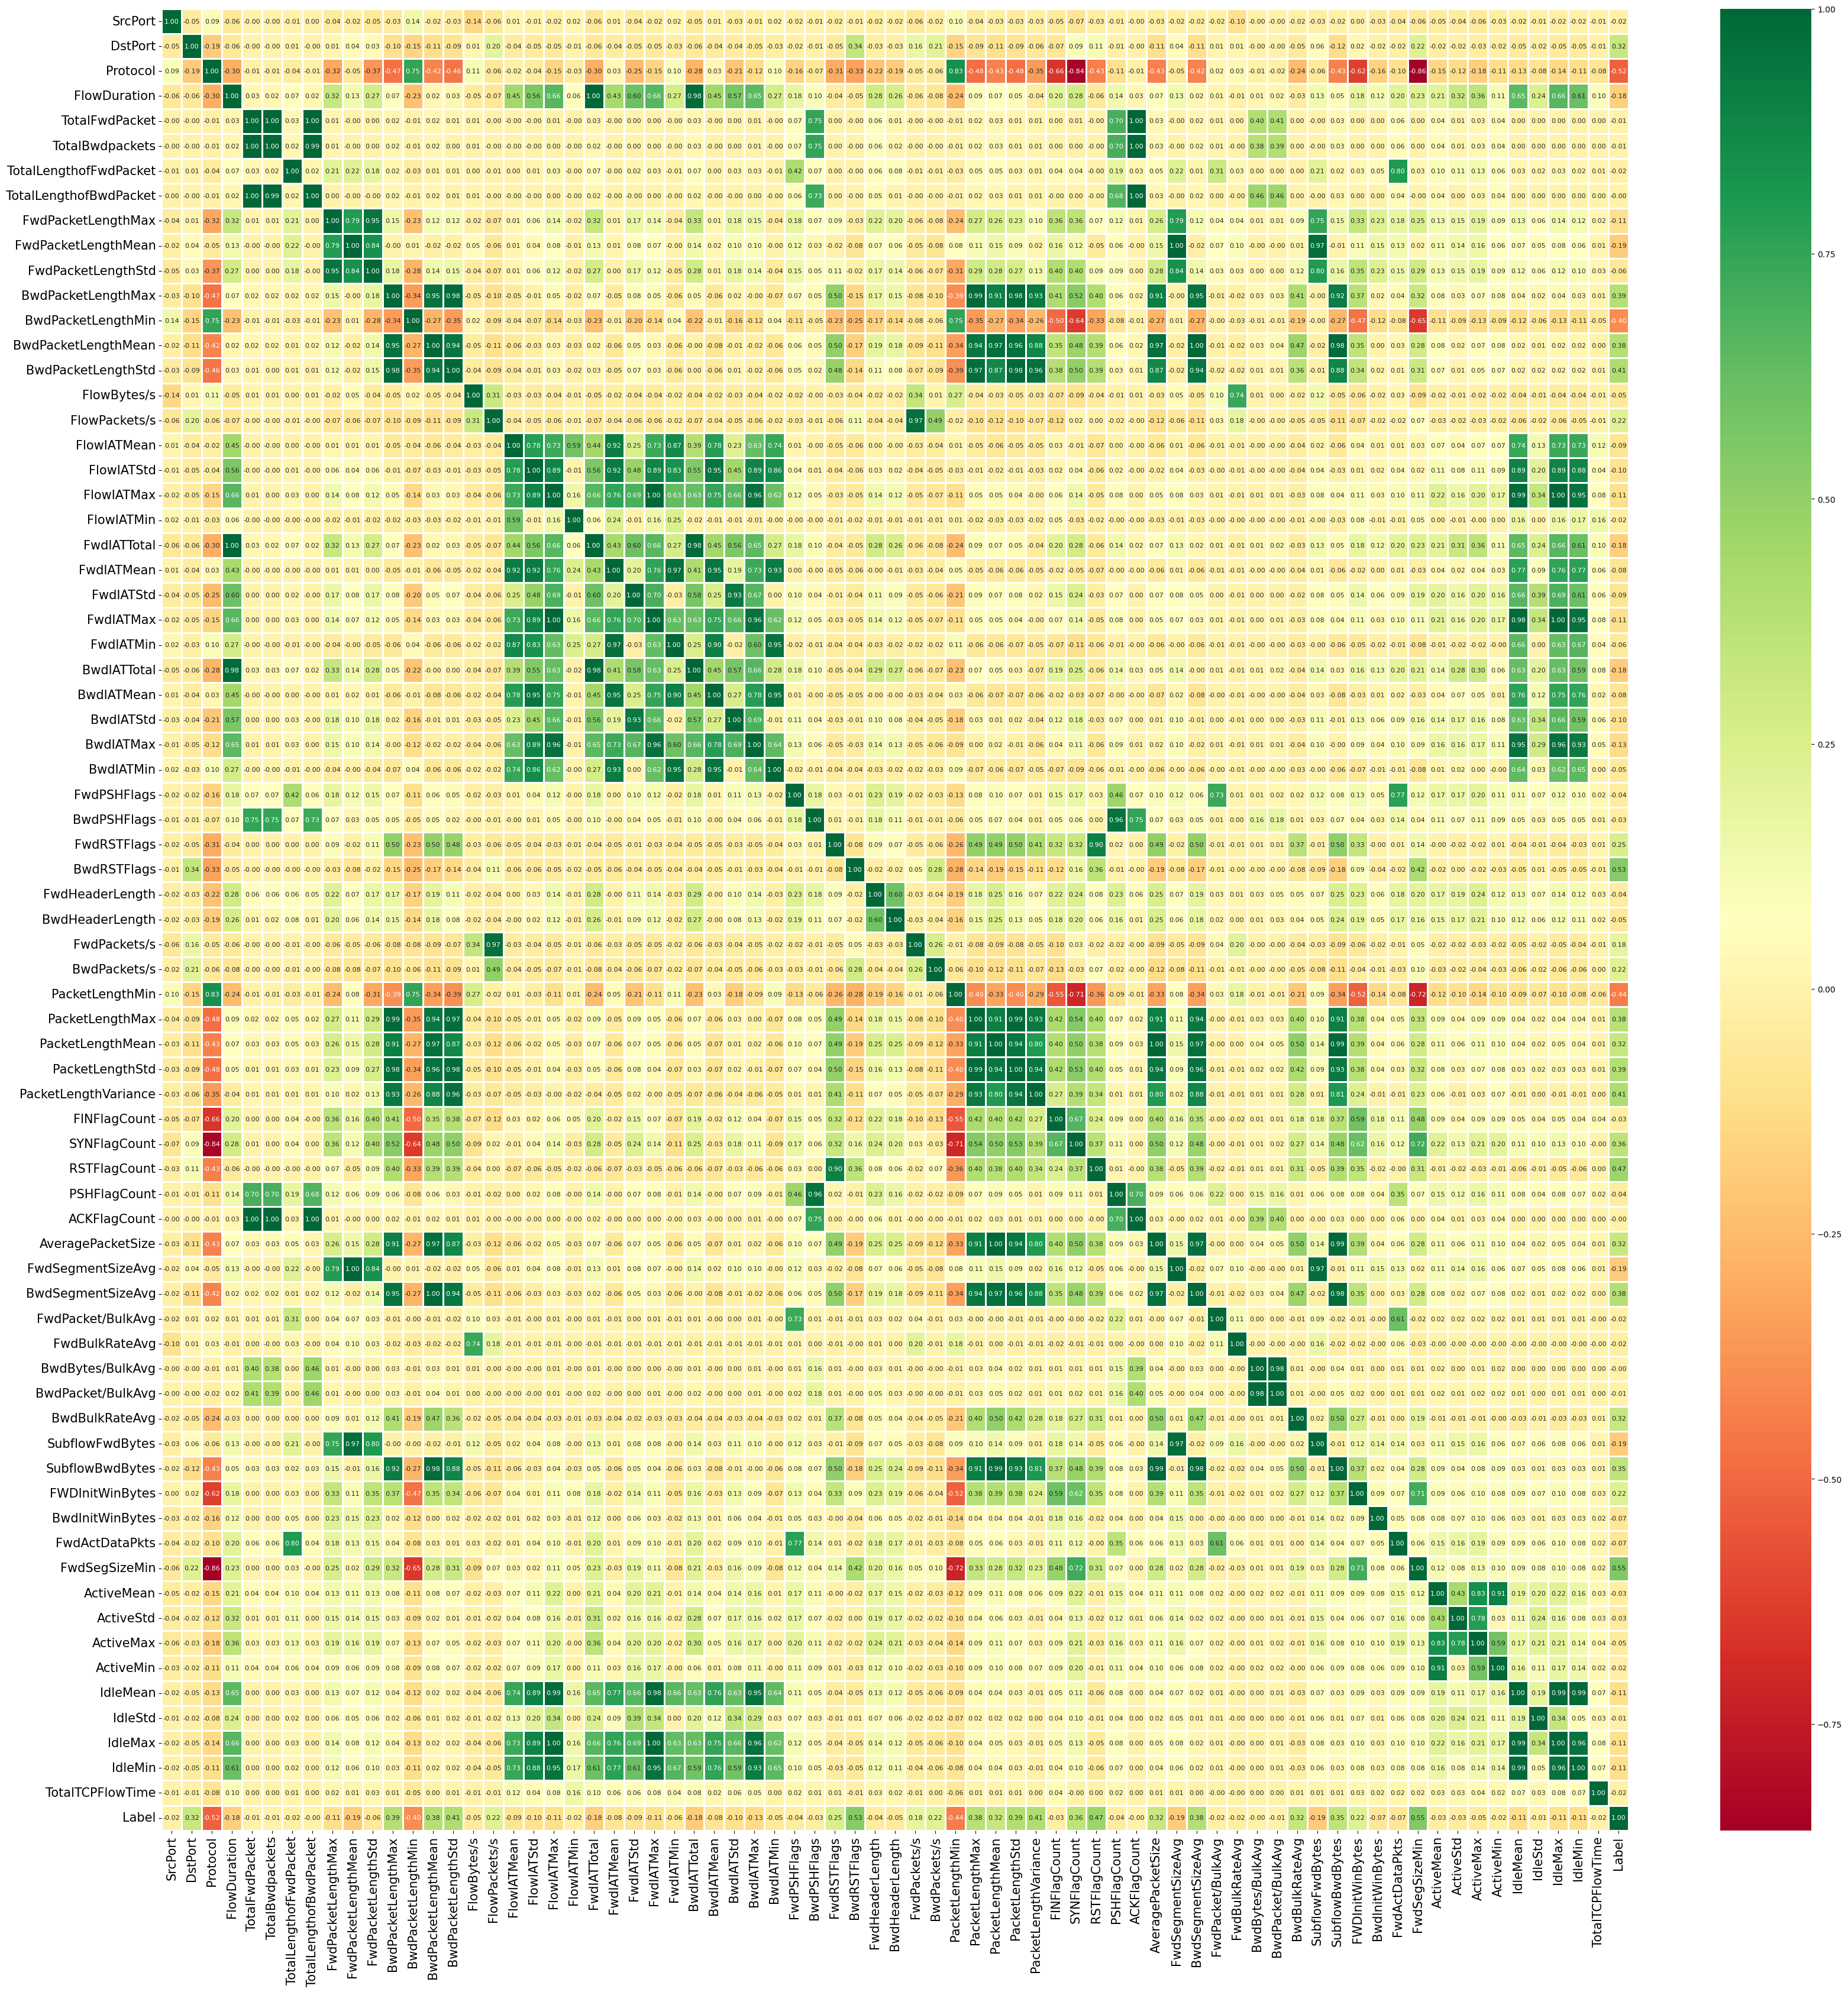

In [ ]:
import matplotlib.pyplot as plt
## plotting a correlation heatmap
plt.gcf().set_size_inches(40, 40)
hm = sns.heatmap(data_corr_mtrx, annot=True, linewidths=.8, annot_kws={"fontsize": 8}, fmt=".2f", cmap="RdYlGn")
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 15)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 15)
images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf/preprocessing'
plt.savefig(f"{images_dir}/corrHeatmapCICIDS2017_completo.pdf", dpi=200, format='pdf', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [ ]:
## process correlation matrix, list highly correlated feature pairs
def srt_corr(mtrx):
    corr_ustack = mtrx.unstack().abs()
    #corr_ustack
    corr_srted = corr_ustack.sort_values(ascending=False)
    return corr_srted

srt_corr(data_corr_mtrx)

AveragePacketSize  PacketLengthMean      1.000000
PacketLengthMean   AveragePacketSize     1.000000
SrcPort            SrcPort               1.000000
BwdIATMean         BwdIATMean            1.000000
FwdIATTotal        FwdIATTotal           1.000000
                                           ...   
FwdIATMean         FwdPacketLengthStd    0.000118
TotalTCPFlowTime   BwdPackets/s          0.000081
BwdPackets/s       TotalTCPFlowTime      0.000081
FwdPSHFlags        FwdIATMean            0.000081
FwdIATMean         FwdPSHFlags           0.000081
Length: 5184, dtype: float64

In [ ]:
from collections import OrderedDict
thres_corr = 0.95
epoch=0
highly_corr = {"dummy": "dummy"}
feats_deled = []

all_data_corr_mtrx2 = data_corr_mtrx.copy()  # for easy
def add_to_dct(l, ft, ft2):
    try:
        l[ft].append(ft2)
    except KeyError:
        l[ft] = [ft2]

get_imp = lambda feat: importances.loc[feat][0]
srt_key = lambda elem: get_imp(elem[0])  # gets imp of first elem

def what_to_del(dct_srt):
    to_del = []  #least imp feature
    for k, val in dct_srt.items():
        ## get all indexes lower than current k
        feats_lw_imp = importances[importances.index.slice_indexer(k)].index
        if set(val) - set(feats_lw_imp):  # feat k creates a corr pair w/ feature of higher importance --- delete feat k
            if k not in to_del: to_del.append(k)
        else:  # feat k creates a corr pair w/ features of lower importnace --- delete one w/ lowest imp
            for ft in feats_lw_imp[::-1]:  # searching from least important
                if ft in val and ft not in to_del:
                    to_del.append(ft)
                    break  ## deleting first founud feat of lowest possible importance
    return to_del


while highly_corr:
    count = 0
    highly_corr.clear()
    for feats, val in srt_corr(all_data_corr_mtrx2).items():
        if val > thres_corr and feats[0] != feats[1]:
            count += 1
            add_to_dct(highly_corr, feats[0], feats[1])
    if not highly_corr: break  # no more highly corr pairs
    highly_corr_srt = OrderedDict(sorted(highly_corr.items(), key=srt_key))  # sorted based on imp

    to_del = what_to_del(highly_corr_srt)
    feats_deled += to_del
    epoch +=1 # first epoch will be 1 not 0!
    print("there are {} higly correlated pairs in {} iteration".format(count, epoch))
    all_data_corr_mtrx2.drop(to_del, axis=1, inplace=True)
    all_data_corr_mtrx2.drop(to_del, axis=0, inplace=True)  # need to remove the feat from both cols and index

print("deleting: {} feature".format(len(feats_deled)))
print("finally deleted:\n"+ "\n".join(feats_deled))

there are 96 higly correlated pairs in 1 iteration
deleting: 25 feature
finally deleted:
BwdIATMin
BwdIATTotal
IdleMax
BwdPacket/BulkAvg
IdleMin
BwdIATMax
FwdIATMin
BwdPSHFlags
TotalBwdpackets
TotalFwdPacket
TotalLengthofBwdPacket
FwdIATTotal
FwdIATMax
SubflowBwdBytes
FwdPackets/s
AveragePacketSize
FwdPacketLengthMean
PacketLengthMean
FwdSegmentSizeAvg
BwdSegmentSizeAvg
BwdPacketLengthMax
PacketLengthMax
BwdPacketLengthMean
PacketLengthVariance
PacketLengthStd


In [ ]:
data = df_importance.copy() ## just for ease of cells executing
data.shape

(2099769, 74)

In [ ]:
#Mantenere BwdPacketLengthMean, BwdPacketLengthMax, FwdIATMin, FwdIATTotal, BwdPacketLengthMean, BwdPacketLengthMax
# items to be removed
unwanted_num = {'BwdPacketLengthMean', 'BwdPacketLengthMax', 'FwdIATMin', 'FwdIATTotal', 'BwdPacketLengthMean', 'BwdPacketLengthMax'}

feats_deled = [ele for ele in feats_deled if ele not in unwanted_num]

data.drop(feats_deled, axis=1, inplace=True)
data_encoded = data.copy()

In [ ]:
data.shape  #26-6 feature tolte per la correlazione

(2099769, 52)

In [ ]:
## plotting a correlation heatmap after removing highly correlated pairs
final_corr_mtrx = data.corr()

plt.gcf().set_size_inches(60, 60)
hm2 = sns.heatmap(final_corr_mtrx, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm2.set_yticklabels(hm2.get_ymajorticklabels(), fontsize = 25)
hm2.set_xticklabels(hm2.get_xmajorticklabels(), fontsize = 25)
plt.savefig(f"{images_dir}/corrHeatmapCICIDS2017after.pdf", dpi=200, format='pdf', bbox_inches = "tight", pad_inches=0.4)
plt.show()

## Encoding

In [ ]:
#SALVO DATASET CSV PRIMA DELL'ENCODING
data.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleaned.csv', index = False)

In [ ]:
df_importance['Label'].value_counts()

BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
Name: Label, dtype: int64

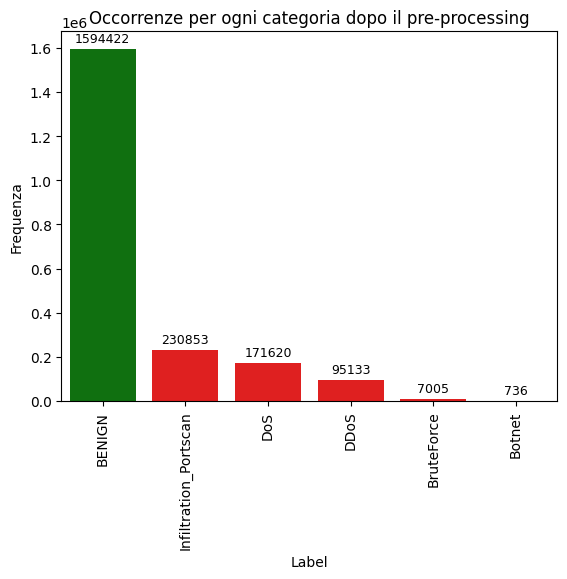

In [ ]:
# Your existing code for creating the palette
orderr = ['BENIGN', 'Infiltration_Portscan', 'DoS', 'DDoS', 'BruteForce', 'Botnet']

palette = {}
for key in orderr:
    palette[key] = "g" if key == "BENIGN" else "r"

# Sort the DataFrame by count in descending order
sorted_df = df_importance['Label'].value_counts().reset_index()
sorted_df.columns = ['Label', 'Count']
sorted_df = sorted_df.sort_values(by='Count', ascending=False)

# Use the 'Label' column for both 'x' and 'hue' in countplot
g = sns.countplot(x='Label', hue='Label', data=df_importance, palette=palette, order=sorted_df['Label'], legend=False)

# Add count values on top of each bar
for p in g.patches:
    g.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Occorrenze per ogni categoria dopo il pre-processing')
plt.xlabel('Label')
plt.xticks(rotation=90)
plt.ylabel('Frequenza')

plt.savefig(f"{images_dir}/distribuzFINALELabelCICIDS2017.pdf", dpi=200, format='pdf', bbox_inches="tight", pad_inches=0.2)
plt.show()


In [ ]:
#####sistemo feature categoriche = feature encoding
data_encoded = df_importance.copy()
#cerco quelle numeriche per poi scremare e trovare le categoriche
cols = data_encoded.columns
num_cols = data_encoded._get_numeric_data().columns
print(list(set(cols) - set(num_cols)))

print("======================")
print(data_encoded.shape)

['Label']
(2099769, 73)


In [ ]:
print(data_encoded['Label'].value_counts()) #6 classi finali per la classificazione del traffico

BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
Name: Label, dtype: int64


In [ ]:
#hot-encoding multi-class
## Label

cat_cols = ["Label"]
cat_cols_encoded = []
for col in cat_cols:
  cat_cols_encoded += [f"{col[0]}_{cat}" for cat in list(data_encoded[col].unique())]

cat_cols_encoded

['L_BENIGN',
 'L_DoS',
 'L_DDoS',
 'L_Infiltration_Portscan',
 'L_Botnet',
 'L_BruteForce']

In [ ]:
#NON FUNZIONA con onehotencoder di preprocessing lib (Dà NaN verso la fine)
#USO DUMMIES

df_finEnc = pd.get_dummies(
    data=data_encoded,
    columns=["Label"],
    prefix=["L"])

df_finEnc.head()

,SrcPort,DstPort,Protocol,FlowDuration,TotalFwdPacket,TotalBwdpackets,TotalLengthofFwdPacket,TotalLengthofBwdPacket,FwdPacketLengthMax,FwdPacketLengthMean,...,IdleStd,IdleMax,IdleMin,TotalTCPFlowTime,L_BENIGN,L_Botnet,L_BruteForce,L_DDoS,L_DoS,L_Infiltration_Portscan
0,58373,53,17,143,2,2,60,344,30,30.00000000000000000000,...,0.00000000000000000000,0,0,0,1,0,0,0,0,0
1,55498,80,6,19007,8,6,415,11595,415,51.87500000000000710543,...,0.00000000000000000000,0,0,19007,0,0,0,0,1,0
2,41854,80,6,5290991,6,6,412,2530,412,68.66666666666667140362,...,0.00000000000000000000,5000095,5000095,5290991,1,0,0,0,0,0
3,62448,443,6,191714,12,7,1275,687,1029,106.25000000000000000000,...,0.00000000000000000000,0,0,191714,1,0,0,0,0,0
4,25896,53,17,157,2,2,68,158,34,34.00000000000000000000,...,0.00000000000000000000,0,0,0,1,0,0,0,0,0


In [ ]:
#SALVO CSV prima del sampling ...potesse servirmi per cambiare e fare altro
df_finEnc.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/dataCleanedEncoded.csv', index = False)

#### Binarizzo IP come encoding - **NO**

In [ ]:
#CIT - https://www.mohammedalani.com/tutorials/handling-ip-addresses-in-machine-learning-datasets/
#not be able to identify the relationship between IP addresses of two hosts within the same network
#BUT
#it can be helpful in recognizing data flows, and doing statistics analysis of data originating or landing in a specific node

## ---------- BINARIZZO IP -------------- #LABEL BINARIZE
train_data = ['127.0.0.1']
df_ipEnc = df_finEnc.copy()
ip_encoder = preprocessing.LabelBinarizer()
print(df_ipEnc["SrcIP"].values[3])
df_ipEnc = ip_encoder.fit_transform(df_ipEnc["SrcIP"].values[3].split('.'))


In [ ]:
print(df_ipEnc)
print("=================")
print(df_ipEnc.tolist())

In [ ]:
#SALVO DATASET CSV PRIMA DELLA NORMALIZZAZIONE
data_encoded.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleanedEncoded.csv', index = False)

#### Splitting IP come encoding - **NO**

In [ ]:
#Splitting IP for DstIP e SrcIP - CIT: Shao Thesis dice che è meglio splittare in 4 feature l'IP
# split the Name column into 4 columns
df_finEnc[['DstIP_1', 'DstIP_2', 'DstIP_3', 'DstIP_4']] = df_finEnc['DstIP'].str.split('.', expand=True)
df_finEnc[['SrcIP_1', 'SrcIP_2', 'SrcIP_3', 'SrcIP_4']] = df_finEnc['SrcIP'].str.split('.', expand=True)
df_finEnc["DstIP_1"] = df_finEnc["DstIP_1"].apply(int)
df_finEnc["DstIP_2"] = df_finEnc["DstIP_2"].apply(int)
df_finEnc["DstIP_3"] = df_finEnc["DstIP_3"].apply(int)
df_finEnc["DstIP_4"] = df_finEnc["DstIP_4"].apply(int)
df_finEnc["SrcIP_1"] = df_finEnc["SrcIP_1"].apply(int)
df_finEnc["SrcIP_2"] = df_finEnc["SrcIP_2"].apply(int)
df_finEnc["SrcIP_3"] = df_finEnc["SrcIP_3"].apply(int)
df_finEnc["SrcIP_4"] = df_finEnc["SrcIP_4"].apply(int)

#elimino colonne SrcIP, DstIP non più utili
df_finEnc = df_finEnc.drop('SrcIP', axis=1)
df_finEnc = df_finEnc.drop('DstIP', axis=1)

df_finEnc

,SrcPort,DstPort,Protocol,FlowDuration,TotalFwdPacket,TotalLengthofFwdPacket,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthStd,...,L_Portscan,L_WebAttacks_Heartbleed,DstIP_1,DstIP_2,DstIP_3,DstIP_4,SrcIP_1,SrcIP_2,SrcIP_3,SrcIP_4
0,57235,53,17,270,2,82,41,41,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,9
1,50194,53,17,1214161,4,128,32,32,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,9
2,49476,53,17,1333756,2,74,37,37,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,19
3,37820,80,6,175982,9,296,296,0,98.666667,1547.981999,...,0,0,192,168,10,50,172,16,0,1
4,64579,53,17,283967,2,86,43,43,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065306,60920,53,17,116473,1,49,49,49,0.000000,0.000000,...,0,0,192,168,10,1,192,168,10,3
2065307,52752,80,6,3559942,7,20,20,0,7.559289,4129.722297,...,0,0,192,168,10,50,172,16,0,1
2065308,61611,443,6,2247446,21,910,341,0,88.258333,679.746241,...,0,0,172,217,10,227,192,168,10,8
2065309,59631,53,17,60745,2,68,34,34,0.000000,0.000000,...,0,0,192,168,10,3,192,168,10,51


In [ ]:
#SALVO DATASET CSV PRIMA DELLA NORMALIZZAZIONE
df_finEnc.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleanedEncoded.csv', index = False)

##Feature Normalization

In [ ]:
df_finEnc['FlowDuration'].isin([0]).any()

False

In [ ]:
###Feature normalization
norm_data = df_finEnc.copy()
print(norm_data.shape) #76 feature totali

(2099769, 78)


In [ ]:
norm_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2099769 entries, 0 to 2099773
Data columns (total 78 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   SrcPort                  int64  
 1   DstPort                  int64  
 2   Protocol                 int64  
 3   FlowDuration             int64  
 4   TotalFwdPacket           int64  
 5   TotalBwdpackets          int64  
 6   TotalLengthofFwdPacket   int64  
 7   TotalLengthofBwdPacket   int64  
 8   FwdPacketLengthMax       int64  
 9   FwdPacketLengthMean      float64
 10  FwdPacketLengthStd       float64
 11  BwdPacketLengthMax       int64  
 12  BwdPacketLengthMin       int64  
 13  BwdPacketLengthMean      float64
 14  BwdPacketLengthStd       float64
 15  FlowBytes/s              float64
 16  FlowPackets/s            float64
 17  FlowIATMean              float64
 18  FlowIATStd               float64
 19  FlowIATMax               int64  
 20  FlowIATMin               int64  
 21  FwdIATTo

In [ ]:
#MIN-MAX SCALING NORMALIZATION - eseguito da FEDANIDS e Li et al. (2023)

x = norm_data.values
normMinMax = preprocessing.MinMaxScaler(feature_range=(0,1))
df_minMaxScal = normMinMax.fit_transform(x)
data_ready = pd.DataFrame(df_minMaxScal, columns=norm_data.columns)

data_ready.head()

,SrcPort,DstPort,Protocol,FlowDuration,TotalFwdPacket,TotalBwdpackets,TotalLengthofFwdPacket,TotalLengthofBwdPacket,FwdPacketLengthMax,FwdPacketLengthMean,...,IdleStd,IdleMax,IdleMin,TotalTCPFlowTime,L_BENIGN,L_Botnet,L_BruteForce,L_DDoS,L_DoS,L_Infiltration_Portscan
0,0.89071488517586028255,0.00080880220970867866,1.00000000000000000000,0.00000118333336291667,0.00000910087868983750,0.00000685114516891498,0.00000466191337978464,0.00000052482840922054,0.00120870265914585018,0.00519435546705912868,...,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
1,0.84684519722285800380,0.00122083352408857153,0.35294117647058820264,0.00015838333729291677,0.00003640351475935002,0.00002055343550674495,0.00003224490087684375,0.00001769007385148897,0.01672038678485092758,0.00898190632845641268,...,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000062749171711272,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000
2,0.63865110246433198782,0.00122083352408857153,0.35294117647058820264,0.04409158443562294361,0.00002730263606951251,0.00002055343550674495,0.00003201180520785452,0.00000385992987013946,0.01659951651893634347,0.01188930251349089653,...,0.00000000000000000000,0.04166755034917368761,0.04166755034917368761,0.00017467527899289403,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
3,0.95289539940489809133,0.00676036563964046554,0.35294117647058820264,0.00159760837327354265,0.00005460527213902503,0.00002397900809120245,0.00009906565932042356,0.00000104813115446080,0.04145850120870266109,0.01839667561250108233,...,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000632919172171030,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000
4,0.39514763103685052181,0.00080880220970867866,1.00000000000000000000,0.00000130000003250000,0.00000910087868983750,0.00000685114516891498,0.00000528350183042259,0.00000024105490888618,0.00136986301369863015,0.00588693619600034676,...,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,1.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000


In [ ]:
#SALVO CSV prima del splitting ...potesse servirmi per cambiare e fare altro
data_ready.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/dataPreprocessed.csv', index = False)

#SPLITTING
* Divisione del dataset pre-processato in Train e Test set
* Applicazione al train set di feature extraction a sessione terminata! Estraggo 35 feature!
* Chiudo sessione ed estraggo le 35 feature anche dal Test set per averlo pronto.

## Splitto

In [ ]:
dataFin = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/dataPreprocessed.csv')

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
label_column = ['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet']

X = dataFin.drop(label_column, axis=1)  # Features
y = dataFin[['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet']]  # Labels

# Initialize StratifiedShuffleSplit with the desired number of splits and random seed
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=5) #70-30 considerando l'imbalanced data

# Perform the split and get indices
for train_index, test_index in stratified_shuffle_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [ ]:
print(X.shape)
print(y.shape)

(2099769, 72)
(2099769, 6)


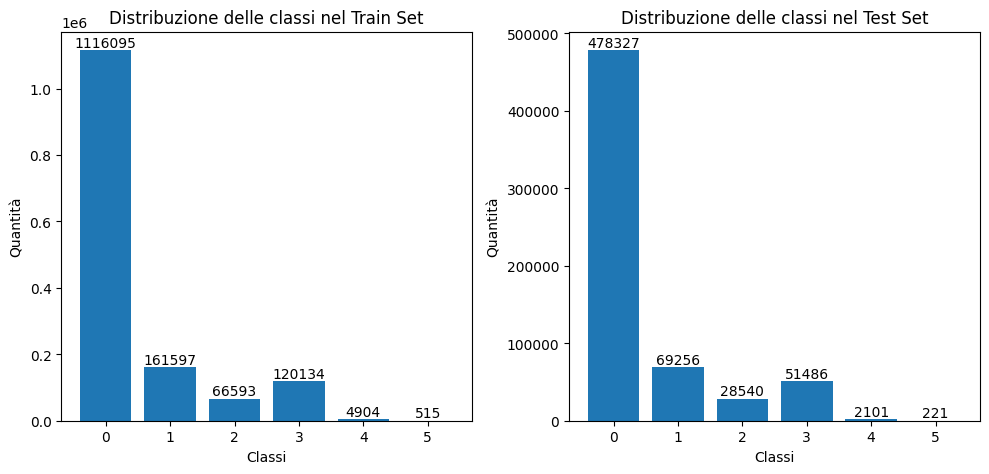

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_class_distribution = pd.Series(np.argmax(y_train, axis=1)).value_counts()
test_class_distribution = pd.Series(np.argmax(y_test, axis=1)).value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].bar_label(axs[0].bar(train_class_distribution.index, train_class_distribution.values), fmt='%d', label_type='edge')
axs[0].set_title('Distribuzione delle classi nel Train Set')
axs[0].set_xlabel('Classi')
axs[0].set_ylabel('Quantità')

axs[1].bar_label(axs[1].bar(test_class_distribution.index, test_class_distribution.values), fmt='%d', label_type='edge')
axs[1].set_title('Distribuzione delle classi nel Test Set')
axs[1].set_xlabel('Classi')
axs[1].set_ylabel('Quantità')

plt.tight_layout()
images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf/preprocessing'
plt.savefig(f"{images_dir}/distributionCICIDS2017preprocessed_TrainvsTestSet.pdf", dpi=200, format='pdf')
plt.show()

In [ ]:
#Salvo TEST SET
X_test.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/X_test_full.csv', index = False)
y_test.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/y_test_full.csv', index = False)

In [ ]:
#SALVO TRAIN SET
X_train.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/X_train_full.csv', index = False)
y_train.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/y_train_full.csv', index = False)

## FEATURE SELECTION sul TRAIN SET

In [ ]:
data_Xtrain = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/X_train_full.csv')
data_ytrain = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/y_train_full.csv')

### Estraggo e salvo

In [ ]:
df_analisiImportanza = pd.read_csv('drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/importancesDF_analysis.csv')

In [ ]:
feature_values_top_35 = df_analisiImportanza.loc[:35, 'Feature'].values
print(feature_values_top_35)

['FlowDuration' 'BwdPacketLengthStd' 'DstPort' 'TotalLengthofFwdPacket'
 'FlowIATMax' 'PacketLengthVariance' 'PacketLengthStd'
 'BwdPacketLengthMax' 'FlowPackets/s' 'RSTFlagCount' 'PacketLengthMax'
 'FwdPacketLengthMax' 'BwdPacketLengthMean' 'PacketLengthMean'
 'SubflowFwdBytes' 'BwdSegmentSizeAvg' 'FwdPackets/s'
 'FwdPacketLengthMean' 'AveragePacketSize' 'FwdSegmentSizeAvg'
 'FlowBytes/s' 'FwdRSTFlags' 'FwdPacketLengthStd' 'SubflowBwdBytes'
 'TotalLengthofBwdPacket' 'FlowIATMean' 'BwdInitWinBytes' 'FwdIATMax'
 'FwdIATStd' 'FwdHeaderLength' 'BwdBulkRateAvg' 'BwdHeaderLength'
 'FwdIATTotal' 'FwdSegSizeMin' 'FWDInitWinBytes' 'BwdPackets/s']


In [ ]:
#estraggo solo 35 feature importanti
# Features are all columns except the one-hot encoded 'Label' columns
data_Xtrain_35 = data_Xtrain[['FlowDuration', 'BwdPacketLengthStd', 'DstPort', 'TotalLengthofFwdPacket',
 'FlowIATMax', 'PacketLengthVariance', 'PacketLengthStd',
 'BwdPacketLengthMax', 'FlowPackets/s', 'RSTFlagCount', 'PacketLengthMax',
 'FwdPacketLengthMax', 'BwdPacketLengthMean', 'PacketLengthMean',
 'SubflowFwdBytes', 'BwdSegmentSizeAvg', 'FwdPackets/s',
 'FwdPacketLengthMean', 'AveragePacketSize', 'FwdSegmentSizeAvg',
 'FlowBytes/s', 'FwdRSTFlags', 'FwdPacketLengthStd', 'SubflowBwdBytes',
 'TotalLengthofBwdPacket', 'FlowIATMean', 'BwdInitWinBytes', 'FwdIATMax',
 'FwdIATStd', 'FwdHeaderLength', 'BwdBulkRateAvg', 'BwdHeaderLength',
 'FwdIATTotal', 'FwdSegSizeMin', 'FWDInitWinBytes', 'BwdPackets/s']]

target = data_ytrain

In [ ]:
#SALVO TRAIN SET
data_Xtrain_35.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/X_train_35.csv', index = False)
target.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/y_train_35.csv', index = False)

## Same per il TEST SET

In [ ]:
data_Xtest = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/X_test_full.csv')
data_ytest = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/y_test_full.csv')

In [ ]:
#estraggo solo 35 feature importanti
# Features are all columns except the one-hot encoded 'Label' columns
data_Xtest_35 = data_Xtest[['FlowDuration', 'BwdPacketLengthStd', 'DstPort', 'TotalLengthofFwdPacket',
 'FlowIATMax', 'PacketLengthVariance', 'PacketLengthStd',
 'BwdPacketLengthMax', 'FlowPackets/s', 'RSTFlagCount', 'PacketLengthMax',
 'FwdPacketLengthMax', 'BwdPacketLengthMean', 'PacketLengthMean',
 'SubflowFwdBytes', 'BwdSegmentSizeAvg', 'FwdPackets/s',
 'FwdPacketLengthMean', 'AveragePacketSize', 'FwdSegmentSizeAvg',
 'FlowBytes/s', 'FwdRSTFlags', 'FwdPacketLengthStd', 'SubflowBwdBytes',
 'TotalLengthofBwdPacket', 'FlowIATMean', 'BwdInitWinBytes', 'FwdIATMax',
 'FwdIATStd', 'FwdHeaderLength', 'BwdBulkRateAvg', 'BwdHeaderLength',
 'FwdIATTotal', 'FwdSegSizeMin', 'FWDInitWinBytes', 'BwdPackets/s']]

In [ ]:
data_Xtest_35.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/X_test_35.csv', index = False)
data_ytest.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/y_test_35.csv', index = False)

## Singoli attacchi con 35 feature

In [ ]:
data_Xtrain = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/X_train_35.csv')
data_ytrain = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/y_train_35.csv')
data35 = pd.concat([data_Xtrain, data_ytrain], axis=1)

print(data_Xtrain.shape)
print(data_ytrain.shape)
print(data35.shape)

(1469838, 36)
(1469838, 6)
(1469838, 42)


In [ ]:
d_Benign = data35[data35['L_BENIGN'] == 1]
d_Portscan = data35[data35['L_Infiltration_Portscan'] == 1]
d_DDoS = data35[data35['L_DDoS'] == 1]
d_DoS = data35[data35['L_DoS'] == 1]
d_BruteForce = data35[data35['L_BruteForce'] == 1]
d_Botnet = data35[data35['L_Botnet'] == 1]

In [ ]:
d_Botnet = d_Botnet.drop(['L_BENIGN', 'L_DoS', 'L_DDoS', 'L_Infiltration_Portscan', 'L_Botnet', 'L_BruteForce'], axis=1)
d_Benign = d_Benign.drop(['L_BENIGN', 'L_DoS', 'L_DDoS', 'L_Infiltration_Portscan', 'L_Botnet', 'L_BruteForce'], axis=1)
d_Portscan = d_Portscan.drop(['L_BENIGN', 'L_DoS', 'L_DDoS', 'L_Infiltration_Portscan', 'L_Botnet', 'L_BruteForce'], axis=1)
d_DDoS = d_DDoS.drop(['L_BENIGN', 'L_DoS', 'L_DDoS', 'L_Infiltration_Portscan', 'L_Botnet', 'L_BruteForce'], axis=1)
d_DoS = d_DoS.drop(['L_BENIGN', 'L_DoS', 'L_DDoS', 'L_Infiltration_Portscan', 'L_Botnet', 'L_BruteForce'], axis=1)
d_BruteForce = d_BruteForce.drop(['L_BENIGN', 'L_DoS', 'L_DDoS', 'L_Infiltration_Portscan', 'L_Botnet', 'L_BruteForce'], axis=1)

In [ ]:
#SALVO CSV
d_Benign.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Benign35.csv', index = False)
d_Portscan.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Portscan35.csv', index = False)
d_DDoS.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_DDoS35.csv', index = False)
d_DoS.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_DoS35.csv', index = False)
d_BruteForce.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_BruteForce35.csv', index = False)
d_Botnet.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Botnet35.csv', index = False)